# **Experiment 03: Training VGG-16 Model (Imagenet) Freezing Dense Layers except the last one on Cifar100 Dataset** #
## Name: Fahim Shahriar ##

## Dataset used: CIFAR100 ##
### About the dataset: ###
Structure of the Dataset
Each of the 100 fine classes belongs to one of 20 coarse classes. This hierarchical labeling allows for both fine-grained and coarse-grained classification tasks.

Coarse Classes (Superclasses) and Their Corresponding Fine Classes:
- Aquatic mammals: beaver, dolphin, otter, seal, whale
- Fish: aquarium fish, flatfish, ray, shark, trout
- Flowers: orchids, poppies, roses, sunflowers, tulips
- Food containers: bottles, bowls, cans, cups, plates
- Fruit and vegetables: apples, mushrooms, oranges, pears, sweet peppers
- Household electrical devices: clock, computer keyboard, lamp, telephone, television
- Household furniture: bed, chair, couch, table, wardrobe
- Insects: bee, beetle, butterfly, caterpillar, cockroach
- Large carnivores: bear, leopard, lion, tiger, wolf
- Large man-made outdoor things: bridge, castle, house, road, skyscraper
- Large natural outdoor scenes: cloud, forest, mountain, plain, sea
- Large omnivores and herbivores: camel, cattle, chimpanzee, elephant, kangaroo
- Medium-sized mammals: fox, porcupine, possum, raccoon, skunk
- Non-insect invertebrates: crab, lobster, snail, spider, worm
- People: baby, boy, girl, man, woman
- Reptiles: crocodile, dinosaur, lizard, snake, turtle
- Small mammals: hamster, mouse, rabbit, shrew, squirrel
- Trees: maple, oak, palm, pine, willow
- Vehicles 1: bicycle, bus, motorcycle, pickup truck, train
- Vehicles 2: lawn-mower, rocket, streetcar, tank, tractor

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from PIL import Image
import torchvision.datasets as dsets
from torchvision.transforms import v2 as transforms
from torchvision import models
import torch.optim as optim
from tqdm import tqdm
import torch
import torch.nn as nn
import pickle
import os
import torch.nn.functional as F
import requests
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn
import pandas as pd
torch.manual_seed(1) # Set manual seed
from sklearn import preprocessing
from torch.utils.data import DataLoader, Dataset, Subset

# Define GPU device - We will run our model on GPU
gpu_device = torch.device("cuda")

import warnings
warnings.filterwarnings('ignore')

## Data Preparation

In [2]:
IMAGE_SIZE = 224

mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
# These values are mostly used by researchers as found to very useful in fast convergence

composed_train = transforms.Compose([ 
    transforms.RandomResizedCrop(IMAGE_SIZE),  # Resize the image to IMAGE_SIZE with a random crop
    transforms.RandomHorizontalFlip(),         # Randomly flip images horizontally    
    transforms.RandomRotation(10),             # Randomly rotate images by 10 degrees
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), fill=tuple([int(x*255) for x in mean])), # Random shift with nearest fill mode
    transforms.ToTensor(),                     # Convert image to tensor
    transforms.Normalize(mean, std)            # Normalize with standard mean and standard deviation
]) 

composed_test = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # Resize to the expected input size of the model
    transforms.ToTensor(),                       # Convert to tensor
    transforms.Normalize(mean=mean, std=std)])

In [3]:
# Load CIFAR-100 dataset
train_dataset = dsets.CIFAR100(root='./data', train=True, download=True, transform=composed_train)
val_dataset = dsets.CIFAR100(root='./data', train=False, download=True, transform=composed_test)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Invalid shape (3, 224, 224) for image data
torch.Size([3, 224, 224]) torch.Size([224, 224, 3])


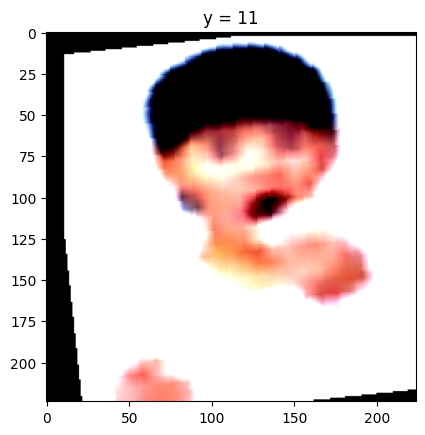

In [4]:
def show_data(img):
    try:
        plt.imshow(img[0])
    except Exception as e:
        print(e)
    print(img[0].shape, img[0].permute(1,2,0).shape)
    plt.imshow(img[0].permute(1,2,0))
    plt.title('y = '+ str(img[1]))
    plt.show()

# We need to convert the images to numpy arrays as tensors are not compatible with matplotlib.
def im_convert(tensor):
    #Lets
    img = tensor.cpu().clone().detach().numpy() #
    img = img.transpose(1, 2, 0)
    img = img * np.array(tuple(mean)) + np.array(tuple(std))
    img = img.clip(0, 1) # Clipping the size to print the images later
    return img

show_data(train_dataset[181])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.8731157].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5528543].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.8858544].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.7633053].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.2385478].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.047

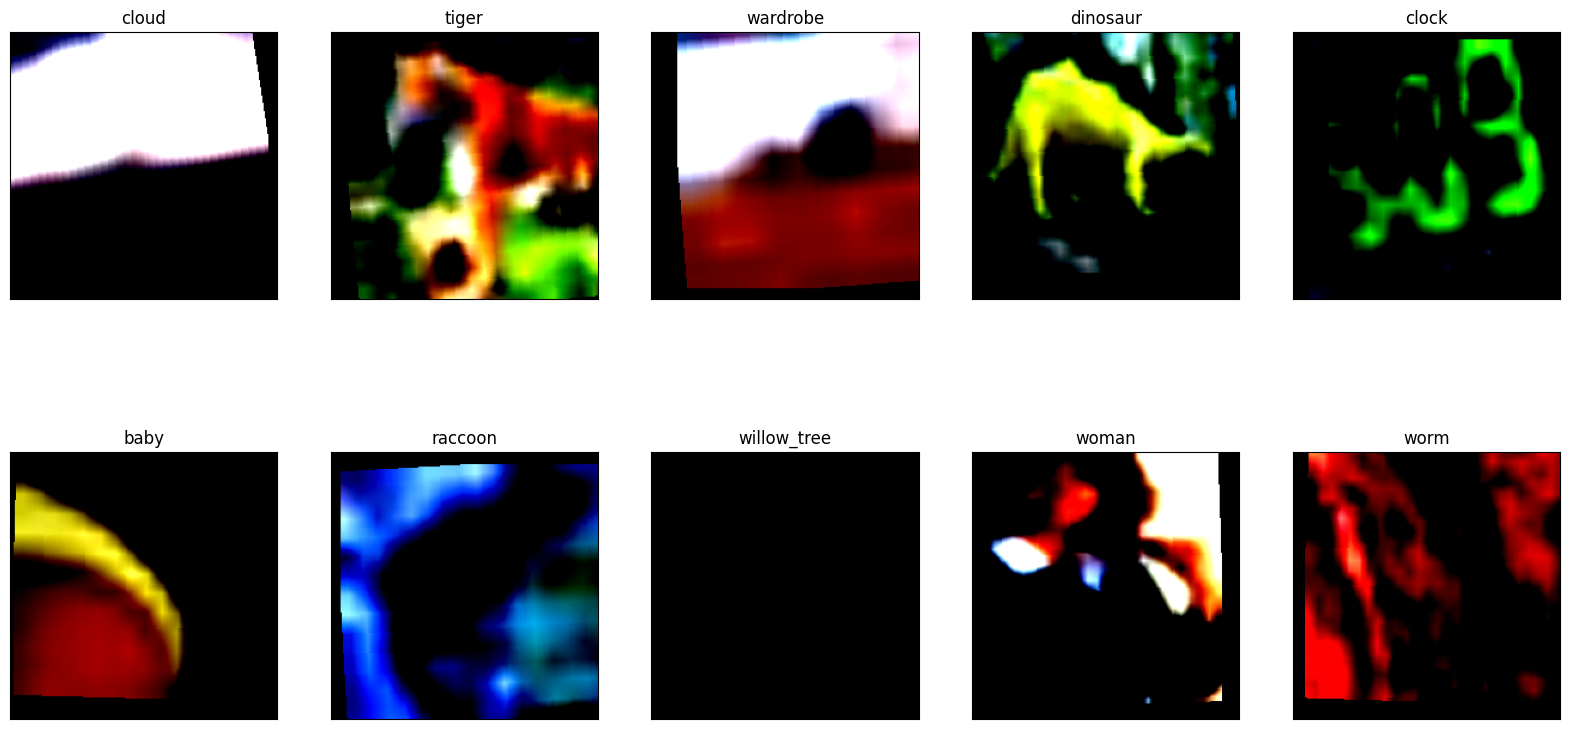

In [5]:
# CIFAR-100 class names
classes = train_dataset.classes

# Function to unnormalize and convert a tensor to a NumPy array
def im_convert(tensor):
    """Imconvert converts tensor to numpy array for matplotlib"""
    image = tensor.clone().detach().numpy()
    #image = image / 2 + 0.5  # unnormalize
    image = np.transpose(image, (1, 2, 0))
    return image

# Define an iterable on the data
data_iterable = iter(train_loader)
images, labels = next(data_iterable)  # getting the first batch of images and labels

# Initialize the figure
fig = plt.figure(figsize=(20, 10))

# Plot 10 images from the training dataset
for idx in np.arange(10):
    ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title(classes[labels[idx].item()])

# Show the plot
plt.show()

## Transfer Learning: **VGG16** 
Freezing all the convolutional layers

## Model Train Function

In [6]:
# Training function with tqdm
def train_model(model, train_loader, validation_loader, optimizer, scheduler, criterion, patience=10, n_epochs=100):
    
    N_test = len(validation_loader.dataset)
    N_train = len(train_loader.dataset)
    train_accuracy_list = []
    val_accuracy_list = []
    train_cost_list = []
    val_cost_list = []

    train_loss_min = np.Inf
    patience_counter = 0

    for epoch in range(n_epochs):
        train_COST = 0
        train_correct = 0
        model.train()
        for x_train, y_train in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{n_epochs}", unit="batch"):
            x_train, y_train = x_train.to(gpu_device), y_train.to(gpu_device)
            optimizer.zero_grad()
            z = model(x_train)
            train_loss = criterion(z, y_train)
            _, yhat = torch.max(z.data, 1)
            train_correct += (yhat == y_train).sum().item()
            train_loss.backward()
            optimizer.step()
            train_COST += train_loss.item()

        train_COST /= len(train_loader)
        train_cost_list.append(train_COST)

        train_accuracy = train_correct / N_train
        train_accuracy_list.append(train_accuracy)

        # Validation
        val_COST = 0
        val_correct = 0
        model.eval()
        with torch.no_grad():
            for x_test, y_test in tqdm(validation_loader, desc=f"Epoch {epoch + 1}/{n_epochs}", unit="batch"):
                x_test, y_test = x_test.to(gpu_device), y_test.to(gpu_device)
                z = model(x_test)
                val_loss = criterion(z, y_test)
                _, yhat = torch.max(z.data, 1)
                val_correct += (yhat == y_test).sum().item()
                val_COST += val_loss.item()

        val_COST /= len(validation_loader)
        val_cost_list.append(val_COST)

        val_accuracy = val_correct / N_test
        val_accuracy_list.append(val_accuracy)

        print(f"--> Epoch Number : {epoch + 1} | Training Loss : {round(train_COST, 4)} | Validation Loss : {round(val_COST, 4)} | Train Accuracy : {round(train_accuracy * 100, 2)}% | Validation Accuracy : {round(val_accuracy * 100, 2)}%")

        # Step the scheduler
        scheduler.step(val_COST)

        if train_COST <= train_loss_min:
            print(f'Train loss decreased ({train_loss_min:.6f} --> {train_COST:.6f}).  Saving model ...')
            torch.save(model.state_dict(), 'model_vgg16_cifar_p03.pt')
            train_loss_min = train_COST
            patience_counter = 0
        else:
            patience_counter += 1
            print(f'EarlyStopping counter: {patience_counter} out of {patience}')
            if patience_counter >= patience:
                print('Early stopping triggered.')
                break

    return train_accuracy_list, val_accuracy_list, train_cost_list, val_cost_list

In [7]:
def vgg_16():
    
    # Load pre-trained VGG-16 model
    vgg = models.vgg16(pretrained=True)

    # Freeze all dense (classifier) layers except the last one
    for param in vgg.classifier[:-1].parameters():
        param.requires_grad = False

    # Update the fully connected layer of VGG-16 with our target of 100 desired outputs
    vgg.classifier[6] = nn.Linear(vgg.classifier[6].in_features, 100)

    # Initialize the weights of the new fully connected layer with Xavier uniform initialization
    torch.nn.init.xavier_uniform_(vgg.classifier[6].weight)
    
    return vgg

# Define the model
model_vgg16_p03 = vgg_16()


In [8]:
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model_vgg16_p03.to(device)

# Visualize the model
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [9]:
!nvidia-smi --query-gpu=memory.used --format=csv

memory.used [MiB]
3001 MiB


In [10]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define model training hyperparameters
criterion = nn.CrossEntropyLoss()
learning_rate = 0.0001
weight_decay = 1e-06

# Initialize the optimizer with specified learning rate and decay
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Define the scheduler
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1)

# Train the model
train_accuracy_list, val_accuracy_list, train_cost_list, val_cost_list = train_model(model=model, 
                                                            n_epochs=50,
                                                            train_loader=train_loader,
                                                            validation_loader=val_loader,
                                                            criterion=criterion,
                                                            scheduler=scheduler,
                                                            optimizer=optimizer)

Epoch 1/50: 100%|█████████████████████████████████████████████████████████████████| 313/313 [00:29<00:00, 10.49batch/s]


--> Epoch Number : 1 | Training Loss : 3.8496 | Validation Loss : 2.7469 | Train Accuracy : 10.14% | Validation Accuracy : 28.53%
Train loss decreased (inf --> 3.849566).  Saving model ...


Epoch 2/50: 100%|█████████████████████████████████████████████████████████████████| 313/313 [00:29<00:00, 10.44batch/s]


--> Epoch Number : 2 | Training Loss : 2.9001 | Validation Loss : 2.0358 | Train Accuracy : 26.23% | Validation Accuracy : 44.96%
Train loss decreased (3.849566 --> 2.900089).  Saving model ...


Epoch 3/50: 100%|█████████████████████████████████████████████████████████████████| 313/313 [00:30<00:00, 10.41batch/s]


--> Epoch Number : 3 | Training Loss : 2.5102 | Validation Loss : 1.766 | Train Accuracy : 35.11% | Validation Accuracy : 50.66%
Train loss decreased (2.900089 --> 2.510234).  Saving model ...


Epoch 4/50: 100%|█████████████████████████████████████████████████████████████████| 313/313 [00:30<00:00, 10.38batch/s]


--> Epoch Number : 4 | Training Loss : 2.2759 | Validation Loss : 1.518 | Train Accuracy : 40.14% | Validation Accuracy : 57.29%
Train loss decreased (2.510234 --> 2.275903).  Saving model ...


Epoch 5/50: 100%|█████████████████████████████████████████████████████████████████| 313/313 [00:31<00:00, 10.09batch/s]


--> Epoch Number : 5 | Training Loss : 2.1388 | Validation Loss : 1.3981 | Train Accuracy : 43.36% | Validation Accuracy : 59.7%
Train loss decreased (2.275903 --> 2.138765).  Saving model ...


Epoch 6/50: 100%|█████████████████████████████████████████████████████████████████| 313/313 [00:31<00:00, 10.04batch/s]


--> Epoch Number : 6 | Training Loss : 2.0295 | Validation Loss : 1.4342 | Train Accuracy : 46.08% | Validation Accuracy : 59.29%
Train loss decreased (2.138765 --> 2.029504).  Saving model ...


Epoch 7/50: 100%|█████████████████████████████████████████████████████████████████| 313/313 [00:31<00:00,  9.86batch/s]


--> Epoch Number : 7 | Training Loss : 1.9377 | Validation Loss : 1.289 | Train Accuracy : 48.41% | Validation Accuracy : 62.83%
Train loss decreased (2.029504 --> 1.937664).  Saving model ...


Epoch 8/50: 100%|█████████████████████████████████████████████████████████████████| 313/313 [00:32<00:00,  9.58batch/s]


--> Epoch Number : 8 | Training Loss : 1.8631 | Validation Loss : 1.2832 | Train Accuracy : 50.23% | Validation Accuracy : 63.57%
Train loss decreased (1.937664 --> 1.863117).  Saving model ...


Epoch 9/50: 100%|█████████████████████████████████████████████████████████████████| 313/313 [00:30<00:00, 10.25batch/s]


--> Epoch Number : 9 | Training Loss : 1.7985 | Validation Loss : 1.3056 | Train Accuracy : 51.84% | Validation Accuracy : 63.6%
Train loss decreased (1.863117 --> 1.798546).  Saving model ...


Epoch 10/50: 100%|████████████████████████████████████████████████████████████████| 313/313 [00:30<00:00, 10.40batch/s]


--> Epoch Number : 10 | Training Loss : 1.7485 | Validation Loss : 1.2383 | Train Accuracy : 53.34% | Validation Accuracy : 64.68%
Train loss decreased (1.798546 --> 1.748544).  Saving model ...


Epoch 11/50: 100%|████████████████████████████████████████████████████████████████| 313/313 [00:30<00:00, 10.42batch/s]


--> Epoch Number : 11 | Training Loss : 1.6991 | Validation Loss : 1.2307 | Train Accuracy : 54.37% | Validation Accuracy : 65.74%
Train loss decreased (1.748544 --> 1.699065).  Saving model ...


Epoch 12/50: 100%|████████████████████████████████████████████████████████████████| 313/313 [00:30<00:00, 10.41batch/s]


--> Epoch Number : 12 | Training Loss : 1.6509 | Validation Loss : 1.1303 | Train Accuracy : 55.74% | Validation Accuracy : 67.84%
Train loss decreased (1.699065 --> 1.650909).  Saving model ...


Epoch 13/50: 100%|████████████████████████████████████████████████████████████████| 313/313 [00:30<00:00, 10.38batch/s]


--> Epoch Number : 13 | Training Loss : 1.6135 | Validation Loss : 1.1098 | Train Accuracy : 56.68% | Validation Accuracy : 67.75%
Train loss decreased (1.650909 --> 1.613505).  Saving model ...


Epoch 14/50: 100%|████████████████████████████████████████████████████████████████| 313/313 [00:29<00:00, 10.45batch/s]


--> Epoch Number : 14 | Training Loss : 1.5683 | Validation Loss : 1.1332 | Train Accuracy : 57.72% | Validation Accuracy : 68.24%
Train loss decreased (1.613505 --> 1.568317).  Saving model ...


Epoch 15/50: 100%|████████████████████████████████████████████████████████████████| 313/313 [00:30<00:00, 10.38batch/s]


--> Epoch Number : 15 | Training Loss : 1.5385 | Validation Loss : 1.157 | Train Accuracy : 58.4% | Validation Accuracy : 67.81%
Train loss decreased (1.568317 --> 1.538548).  Saving model ...


Epoch 16/50: 100%|████████████████████████████████████████████████████████████████| 313/313 [00:30<00:00, 10.41batch/s]


--> Epoch Number : 16 | Training Loss : 1.5054 | Validation Loss : 1.1277 | Train Accuracy : 59.19% | Validation Accuracy : 68.73%
Train loss decreased (1.538548 --> 1.505428).  Saving model ...


Epoch 17/50: 100%|████████████████████████████████████████████████████████████████| 313/313 [00:30<00:00, 10.43batch/s]


--> Epoch Number : 17 | Training Loss : 1.4781 | Validation Loss : 1.0871 | Train Accuracy : 60.09% | Validation Accuracy : 69.35%
Train loss decreased (1.505428 --> 1.478081).  Saving model ...


Epoch 18/50: 100%|████████████████████████████████████████████████████████████████| 313/313 [00:30<00:00, 10.38batch/s]


--> Epoch Number : 18 | Training Loss : 1.4381 | Validation Loss : 1.1226 | Train Accuracy : 60.93% | Validation Accuracy : 69.05%
Train loss decreased (1.478081 --> 1.438065).  Saving model ...


Epoch 19/50: 100%|████████████████████████████████████████████████████████████████| 313/313 [00:30<00:00, 10.42batch/s]


--> Epoch Number : 19 | Training Loss : 1.4117 | Validation Loss : 1.112 | Train Accuracy : 61.52% | Validation Accuracy : 69.07%
Train loss decreased (1.438065 --> 1.411657).  Saving model ...


Epoch 20/50: 100%|████████████████████████████████████████████████████████████████| 313/313 [00:30<00:00, 10.42batch/s]


--> Epoch Number : 20 | Training Loss : 1.4039 | Validation Loss : 1.0737 | Train Accuracy : 62.15% | Validation Accuracy : 70.19%
Train loss decreased (1.411657 --> 1.403885).  Saving model ...


Epoch 21/50: 100%|████████████████████████████████████████████████████████████████| 313/313 [00:30<00:00, 10.32batch/s]


--> Epoch Number : 21 | Training Loss : 1.3563 | Validation Loss : 1.116 | Train Accuracy : 63.37% | Validation Accuracy : 69.64%
Train loss decreased (1.403885 --> 1.356283).  Saving model ...


Epoch 22/50: 100%|████████████████████████████████████████████████████████████████| 313/313 [00:30<00:00, 10.28batch/s]


--> Epoch Number : 22 | Training Loss : 1.3491 | Validation Loss : 1.0866 | Train Accuracy : 63.32% | Validation Accuracy : 69.85%
Train loss decreased (1.356283 --> 1.349054).  Saving model ...


Epoch 23/50: 100%|████████████████████████████████████████████████████████████████| 313/313 [00:30<00:00, 10.34batch/s]


--> Epoch Number : 23 | Training Loss : 1.3308 | Validation Loss : 1.0866 | Train Accuracy : 63.62% | Validation Accuracy : 70.71%
Train loss decreased (1.349054 --> 1.330759).  Saving model ...


Epoch 24/50: 100%|████████████████████████████████████████████████████████████████| 313/313 [00:30<00:00, 10.29batch/s]


--> Epoch Number : 24 | Training Loss : 1.3043 | Validation Loss : 1.1245 | Train Accuracy : 64.68% | Validation Accuracy : 69.63%
Train loss decreased (1.330759 --> 1.304262).  Saving model ...


Epoch 25/50: 100%|████████████████████████████████████████████████████████████████| 313/313 [00:30<00:00, 10.33batch/s]


--> Epoch Number : 25 | Training Loss : 1.2873 | Validation Loss : 1.0379 | Train Accuracy : 64.91% | Validation Accuracy : 71.25%
Train loss decreased (1.304262 --> 1.287305).  Saving model ...


Epoch 26/50: 100%|████████████████████████████████████████████████████████████████| 313/313 [00:33<00:00,  9.36batch/s]


--> Epoch Number : 26 | Training Loss : 1.2677 | Validation Loss : 1.0804 | Train Accuracy : 65.59% | Validation Accuracy : 71.42%
Train loss decreased (1.287305 --> 1.267676).  Saving model ...


Epoch 27/50: 100%|████████████████████████████████████████████████████████████████| 313/313 [00:31<00:00,  9.96batch/s]


--> Epoch Number : 27 | Training Loss : 1.2626 | Validation Loss : 1.1102 | Train Accuracy : 65.77% | Validation Accuracy : 71.08%
Train loss decreased (1.267676 --> 1.262617).  Saving model ...


Epoch 28/50: 100%|████████████████████████████████████████████████████████████████| 313/313 [00:31<00:00, 10.03batch/s]


--> Epoch Number : 28 | Training Loss : 1.2412 | Validation Loss : 1.1056 | Train Accuracy : 66.14% | Validation Accuracy : 71.02%
Train loss decreased (1.262617 --> 1.241188).  Saving model ...


Epoch 29/50: 100%|████████████████████████████████████████████████████████████████| 313/313 [00:30<00:00, 10.34batch/s]


--> Epoch Number : 29 | Training Loss : 1.2179 | Validation Loss : 1.076 | Train Accuracy : 66.79% | Validation Accuracy : 71.49%
Train loss decreased (1.241188 --> 1.217896).  Saving model ...


Epoch 30/50: 100%|████████████████████████████████████████████████████████████████| 313/313 [00:30<00:00, 10.22batch/s]


--> Epoch Number : 30 | Training Loss : 1.197 | Validation Loss : 1.153 | Train Accuracy : 67.33% | Validation Accuracy : 70.73%
Train loss decreased (1.217896 --> 1.196989).  Saving model ...


Epoch 31/50: 100%|████████████████████████████████████████████████████████████████| 313/313 [00:31<00:00, 10.04batch/s]


--> Epoch Number : 31 | Training Loss : 1.181 | Validation Loss : 1.1258 | Train Accuracy : 67.82% | Validation Accuracy : 71.0%
Train loss decreased (1.196989 --> 1.180960).  Saving model ...


Epoch 32/50: 100%|████████████████████████████████████████████████████████████████| 313/313 [00:30<00:00, 10.20batch/s]


--> Epoch Number : 32 | Training Loss : 1.0 | Validation Loss : 1.0555 | Train Accuracy : 72.67% | Validation Accuracy : 74.33%
Train loss decreased (1.180960 --> 1.000033).  Saving model ...


Epoch 33/50: 100%|████████████████████████████████████████████████████████████████| 313/313 [00:30<00:00, 10.14batch/s]


--> Epoch Number : 33 | Training Loss : 0.9331 | Validation Loss : 1.0547 | Train Accuracy : 74.26% | Validation Accuracy : 74.3%
Train loss decreased (1.000033 --> 0.933088).  Saving model ...


Epoch 34/50: 100%|████████████████████████████████████████████████████████████████| 313/313 [00:31<00:00,  9.79batch/s]


--> Epoch Number : 34 | Training Loss : 0.9332 | Validation Loss : 1.0531 | Train Accuracy : 74.61% | Validation Accuracy : 74.65%
EarlyStopping counter: 1 out of 10


Epoch 35/50: 100%|████████████████████████████████████████████████████████████████| 313/313 [00:32<00:00,  9.71batch/s]


--> Epoch Number : 35 | Training Loss : 0.9092 | Validation Loss : 1.0709 | Train Accuracy : 75.12% | Validation Accuracy : 74.72%
Train loss decreased (0.933088 --> 0.909163).  Saving model ...


Epoch 36/50: 100%|████████████████████████████████████████████████████████████████| 313/313 [00:30<00:00, 10.19batch/s]


--> Epoch Number : 36 | Training Loss : 0.9033 | Validation Loss : 1.0806 | Train Accuracy : 75.3% | Validation Accuracy : 74.82%
Train loss decreased (0.909163 --> 0.903282).  Saving model ...


Epoch 37/50: 100%|████████████████████████████████████████████████████████████████| 313/313 [00:30<00:00, 10.43batch/s]


--> Epoch Number : 37 | Training Loss : 0.8806 | Validation Loss : 1.096 | Train Accuracy : 75.91% | Validation Accuracy : 74.73%
Train loss decreased (0.903282 --> 0.880598).  Saving model ...


Epoch 38/50: 100%|████████████████████████████████████████████████████████████████| 313/313 [00:29<00:00, 10.47batch/s]


--> Epoch Number : 38 | Training Loss : 0.8661 | Validation Loss : 1.091 | Train Accuracy : 76.22% | Validation Accuracy : 74.88%
Train loss decreased (0.880598 --> 0.866106).  Saving model ...


Epoch 39/50: 100%|████████████████████████████████████████████████████████████████| 313/313 [00:29<00:00, 10.44batch/s]


--> Epoch Number : 39 | Training Loss : 0.8657 | Validation Loss : 1.087 | Train Accuracy : 76.17% | Validation Accuracy : 74.94%
Train loss decreased (0.866106 --> 0.865722).  Saving model ...


Epoch 40/50: 100%|████████████████████████████████████████████████████████████████| 313/313 [00:29<00:00, 10.45batch/s]


--> Epoch Number : 40 | Training Loss : 0.8613 | Validation Loss : 1.0853 | Train Accuracy : 76.39% | Validation Accuracy : 75.0%
Train loss decreased (0.865722 --> 0.861263).  Saving model ...


Epoch 41/50: 100%|████████████████████████████████████████████████████████████████| 313/313 [00:29<00:00, 10.44batch/s]


--> Epoch Number : 41 | Training Loss : 0.8435 | Validation Loss : 1.0896 | Train Accuracy : 76.83% | Validation Accuracy : 75.07%
Train loss decreased (0.861263 --> 0.843471).  Saving model ...


Epoch 42/50: 100%|████████████████████████████████████████████████████████████████| 313/313 [00:29<00:00, 10.46batch/s]


--> Epoch Number : 42 | Training Loss : 0.8539 | Validation Loss : 1.0877 | Train Accuracy : 76.51% | Validation Accuracy : 74.84%
EarlyStopping counter: 1 out of 10


Epoch 43/50: 100%|████████████████████████████████████████████████████████████████| 313/313 [00:29<00:00, 10.44batch/s]


--> Epoch Number : 43 | Training Loss : 0.8591 | Validation Loss : 1.089 | Train Accuracy : 76.64% | Validation Accuracy : 75.06%
EarlyStopping counter: 2 out of 10


Epoch 44/50: 100%|████████████████████████████████████████████████████████████████| 313/313 [00:29<00:00, 10.45batch/s]


--> Epoch Number : 44 | Training Loss : 0.8522 | Validation Loss : 1.0887 | Train Accuracy : 76.6% | Validation Accuracy : 74.97%
EarlyStopping counter: 3 out of 10


Epoch 45/50: 100%|████████████████████████████████████████████████████████████████| 313/313 [00:30<00:00, 10.27batch/s]


--> Epoch Number : 45 | Training Loss : 0.8532 | Validation Loss : 1.0879 | Train Accuracy : 76.5% | Validation Accuracy : 74.95%
EarlyStopping counter: 4 out of 10


Epoch 46/50: 100%|████████████████████████████████████████████████████████████████| 313/313 [00:29<00:00, 10.46batch/s]


--> Epoch Number : 46 | Training Loss : 0.8511 | Validation Loss : 1.089 | Train Accuracy : 76.77% | Validation Accuracy : 75.01%
EarlyStopping counter: 5 out of 10


Epoch 47/50: 100%|████████████████████████████████████████████████████████████████| 313/313 [00:29<00:00, 10.44batch/s]


--> Epoch Number : 47 | Training Loss : 0.8542 | Validation Loss : 1.0886 | Train Accuracy : 76.63% | Validation Accuracy : 74.97%
EarlyStopping counter: 6 out of 10


Epoch 48/50: 100%|████████████████████████████████████████████████████████████████| 313/313 [00:30<00:00, 10.32batch/s]


--> Epoch Number : 48 | Training Loss : 0.8495 | Validation Loss : 1.0883 | Train Accuracy : 76.71% | Validation Accuracy : 74.96%
EarlyStopping counter: 7 out of 10


Epoch 49/50: 100%|████████████████████████████████████████████████████████████████| 313/313 [00:30<00:00, 10.28batch/s]


--> Epoch Number : 49 | Training Loss : 0.8467 | Validation Loss : 1.0881 | Train Accuracy : 76.79% | Validation Accuracy : 74.95%
EarlyStopping counter: 8 out of 10


Epoch 50/50: 100%|████████████████████████████████████████████████████████████████| 313/313 [00:31<00:00, 10.06batch/s]

--> Epoch Number : 50 | Training Loss : 0.8516 | Validation Loss : 1.0881 | Train Accuracy : 76.6% | Validation Accuracy : 74.95%
EarlyStopping counter: 9 out of 10


In [11]:
model.load_state_dict(torch.load('model_vgg16_cifar_p03.pt'))

<All keys matched successfully>

## Model Performance Report and Error Analysis

### Results of all the 50 epochs

In [13]:
def results_epoch(epochs, train_acc, val_acc, train_cost, val_cost):
    min_length = min(len(train_acc), len(val_acc), len(train_cost), len(val_cost), epochs)
    
    for epoch in range(min_length):
        print(f"Epoch {epoch + 1} ---> Train Accuracy: {train_acc[epoch] * 100:.3f}   |   Validation Accuracy: {val_acc[epoch] * 100:.3f}   |   Train Loss: {train_cost[epoch]:.3f}   |   Validation Loss: {val_cost[epoch]:.3f}\n")

# Example usage
results_epoch(
    epochs=50, 
    train_acc=train_accuracy_list, 
    val_acc=val_accuracy_list, 
    train_cost=train_cost_list, 
    val_cost=val_cost_list
)

Epoch 1 ---> Train Accuracy: 10.144   |   Validation Accuracy: 28.530   |   Train Loss: 3.850   |   Validation Loss: 2.747

Epoch 2 ---> Train Accuracy: 26.228   |   Validation Accuracy: 44.960   |   Train Loss: 2.900   |   Validation Loss: 2.036

Epoch 3 ---> Train Accuracy: 35.112   |   Validation Accuracy: 50.660   |   Train Loss: 2.510   |   Validation Loss: 1.766

Epoch 4 ---> Train Accuracy: 40.136   |   Validation Accuracy: 57.290   |   Train Loss: 2.276   |   Validation Loss: 1.518

Epoch 5 ---> Train Accuracy: 43.358   |   Validation Accuracy: 59.700   |   Train Loss: 2.139   |   Validation Loss: 1.398

Epoch 6 ---> Train Accuracy: 46.078   |   Validation Accuracy: 59.290   |   Train Loss: 2.030   |   Validation Loss: 1.434

Epoch 7 ---> Train Accuracy: 48.414   |   Validation Accuracy: 62.830   |   Train Loss: 1.938   |   Validation Loss: 1.289

Epoch 8 ---> Train Accuracy: 50.234   |   Validation Accuracy: 63.570   |   Train Loss: 1.863   |   Validation Loss: 1.283

Epoch 9 

### Visualizing

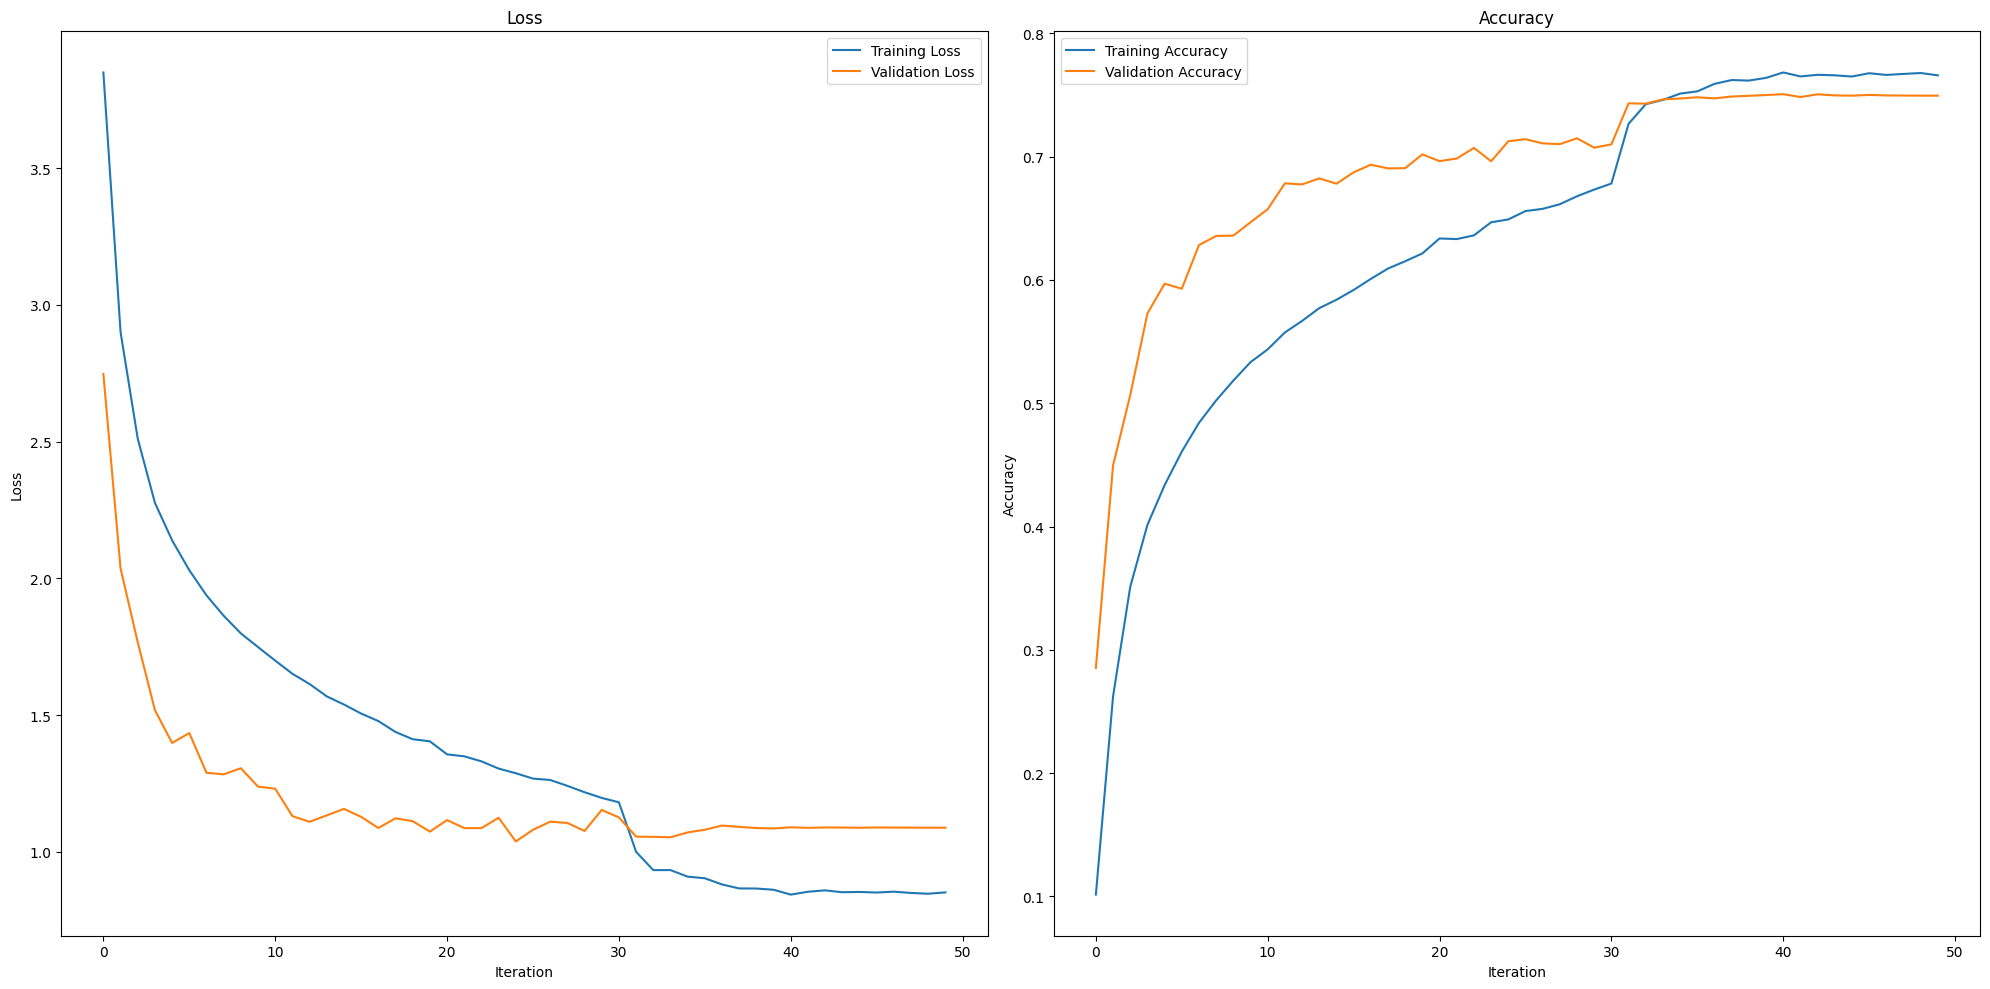

In [14]:
# Create a figure with 2 subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Plot training and validation losses on the first subplot
ax1.plot(train_cost_list, label='Training Loss')
ax1.plot(val_cost_list, label='Validation Loss')
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Loss")
ax1.set_title("Loss")
ax1.legend()

# Plot training and validation accuracies on the second subplot
ax2.plot(train_accuracy_list, label='Training Accuracy')
ax2.plot(val_accuracy_list, label='Validation Accuracy')
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Accuracy")
ax2.set_title("Accuracy")
ax2.legend()

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()


### Classification Report

In [16]:
# Lists to store true labels and predictions
y_pred = []
y_true = []

# Iterate over validation data
for x, y in torch.utils.data.DataLoader(dataset=val_dataset, batch_size=1):
    x = x.to(gpu_device)
    y = y.to(gpu_device)
    
    # Forward pass
    with torch.no_grad():
        z = model(x)
        _, yhat = torch.max(z, 1)
        pred = yhat.data.cpu().numpy()
        y_pred.extend(pred)  # Save prediction
        
        labels = y.data.cpu().numpy()
        y_true.extend(labels)  # Save truth

# Generate classification report
report = classification_report(y_true, y_pred, target_names=[str(i) for i in classes])
print(report)


               precision    recall  f1-score   support

        apple       0.96      0.90      0.93       100
aquarium_fish       0.88      0.85      0.86       100
         baby       0.71      0.75      0.73       100
         bear       0.69      0.63      0.66       100
       beaver       0.57      0.61      0.59       100
          bed       0.68      0.78      0.73       100
          bee       0.79      0.76      0.78       100
       beetle       0.72      0.83      0.77       100
      bicycle       0.93      0.89      0.91       100
       bottle       0.83      0.81      0.82       100
         bowl       0.55      0.52      0.54       100
          boy       0.52      0.52      0.52       100
       bridge       0.72      0.84      0.78       100
          bus       0.76      0.65      0.70       100
    butterfly       0.70      0.72      0.71       100
        camel       0.76      0.77      0.77       100
          can       0.70      0.78      0.74       100
       ca

In [18]:
report_dict = classification_report(y_true, y_pred, target_names=[str(i) for i in classes], output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
report_df

,precision,recall,f1-score,support
apple,0.957447,0.9000,0.927835,100.0000
aquarium_fish,0.876289,0.8500,0.862944,100.0000
baby,0.714286,0.7500,0.731707,100.0000
bear,0.692308,0.6300,0.659686,100.0000
beaver,0.570093,0.6100,0.589372,100.0000
...,...,...,...,...
woman,0.582524,0.6000,0.591133,100.0000
worm,0.780000,0.7800,0.780000,100.0000
accuracy,0.750700,0.7507,0.750700,0.7507
macro avg,0.754417,0.7507,0.750863,10000.0000


### Convertinng classification report into docx file

In [21]:
from docx import Document
from docx.shared import Pt

report_df = report_df.applymap(lambda x: f'{x:.4f}' if isinstance(x, float) else x)

# Save the DataFrame as a Word document
doc = Document()

# Add a title
doc.add_heading('Classification Report-03', level=1)

# Add a table
table = doc.add_table(rows=1, cols=len(report_df.columns) + 1)
table.style = 'Table Grid'

# Add the header row
hdr_cells = table.rows[0].cells
hdr_cells[0].text = 'Class'
for i, column_name in enumerate(report_df.columns):
    hdr_cells[i + 1].text = column_name

# Add the data rows
for idx, row in report_df.iterrows():
    row_cells = table.add_row().cells
    row_cells[0].text = str(idx)
    for i, value in enumerate(row):
        row_cells[i + 1].text = str(value)

# Save the document
doc.save('classification_report-03.docx')

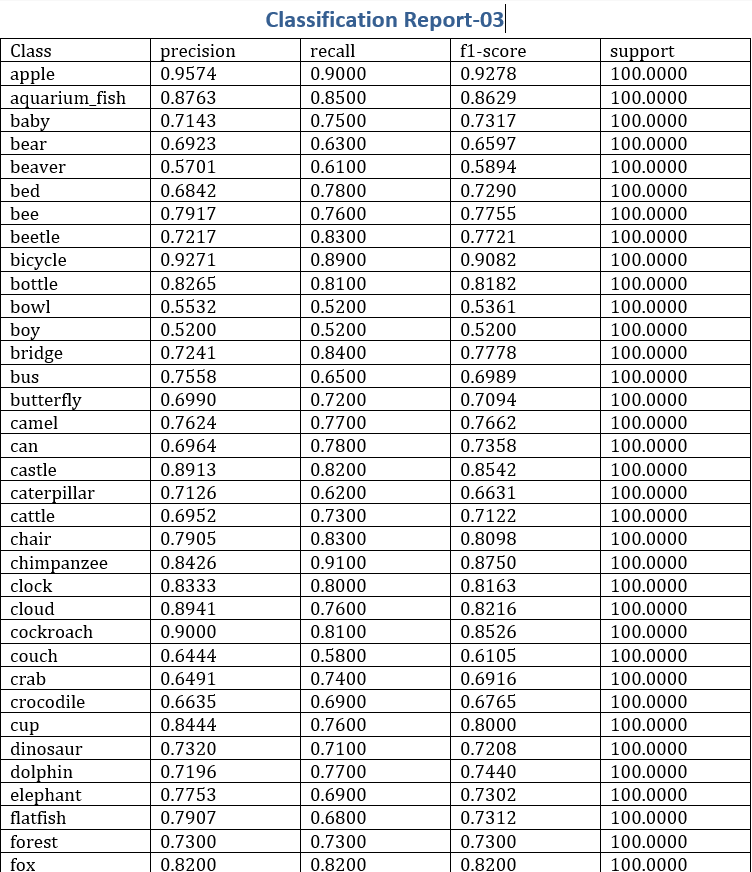

### ROC plot

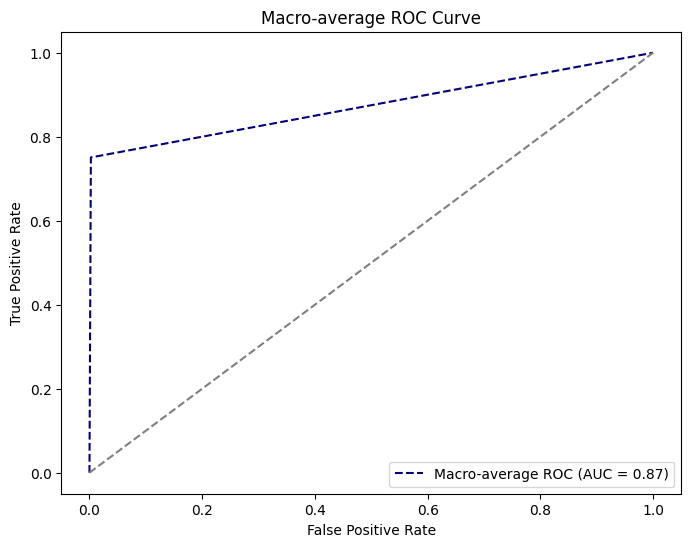

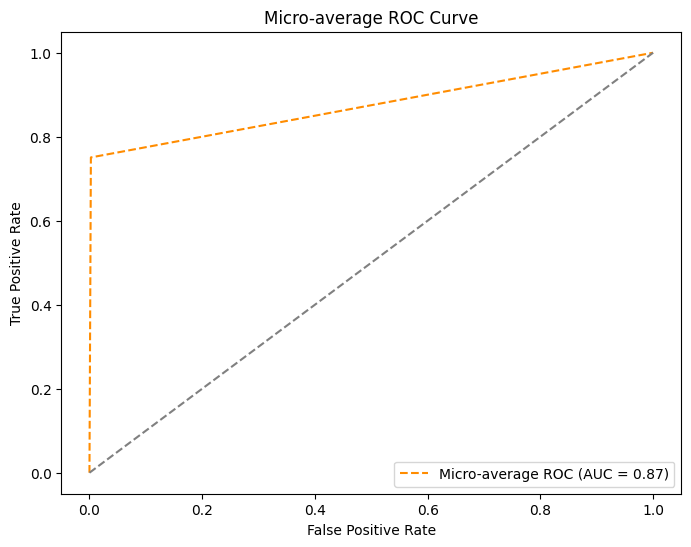

In [22]:
from sklearn.metrics import roc_curve, auc

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Check if y_pred is 1D (representing class predictions) or 2D (representing probabilities/scores)
if len(y_pred.shape) == 1:
    # Convert class predictions to one-hot encoded format
    y_pred_one_hot = np.zeros((len(y_true), np.max(y_pred) + 1))
    y_pred_one_hot[np.arange(len(y_true)), y_pred] = 1
    y_pred = y_pred_one_hot

# Compute the number of classes
num_classes = y_pred.shape[1]

# If y_true is one-dimensional, convert it to one-hot encoded format
if len(y_true.shape) == 1:
    y_true_one_hot = np.zeros((len(y_true), num_classes))
    y_true_one_hot[np.arange(len(y_true)), y_true] = 1
    y_true = y_true_one_hot

# Initialize lists to store fpr and tpr for each class
all_fpr = []
all_tpr = []
all_auc = []

# Compute ROC curve and AUC for each class
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_auc.append(roc_auc)

# Compute the macro-average ROC curve by averaging the fpr and tpr across all classes
mean_fpr = np.mean(all_fpr, axis=0)
mean_tpr = np.mean(all_tpr, axis=0)

# Compute the macro-average AUC
macro_auc = auc(mean_fpr, mean_tpr)

# Plot the macro-average ROC curve
plt.figure(figsize=(8, 6))
plt.plot(mean_fpr, mean_tpr, label=f'Macro-average ROC (AUC = {macro_auc:.2f})', color='navy', linestyle='--')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Macro-average ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Compute micro-average ROC curve and AUC
micro_fpr, micro_tpr, _ = roc_curve(y_true.ravel(), y_pred.ravel())
micro_auc = auc(micro_fpr, micro_tpr)

# Plot the micro-average ROC curve
plt.figure(figsize=(8, 6))
plt.plot(micro_fpr, micro_tpr, label=f'Micro-average ROC (AUC = {micro_auc:.2f})', color='darkorange', linestyle='--')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average ROC Curve')
plt.legend(loc='lower right')
plt.show()


## Miss-classification

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8044444..2.2009804].


Invalid shape (3, 224, 224) for image data
torch.Size([3, 224, 224]) torch.Size([224, 224, 3])


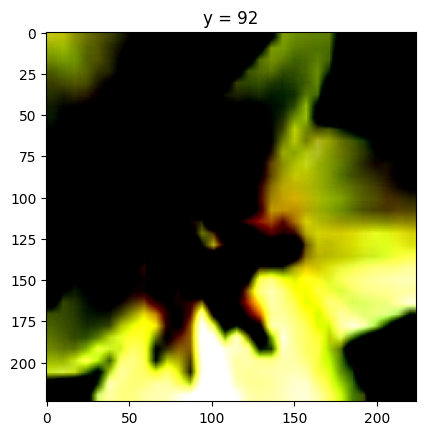

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6726604..1.6495419].


True label:  tulip
Predicted label:  orchid

---------------------------------------------------------------------

Invalid shape (3, 224, 224) for image data
torch.Size([3, 224, 224]) torch.Size([224, 224, 3])


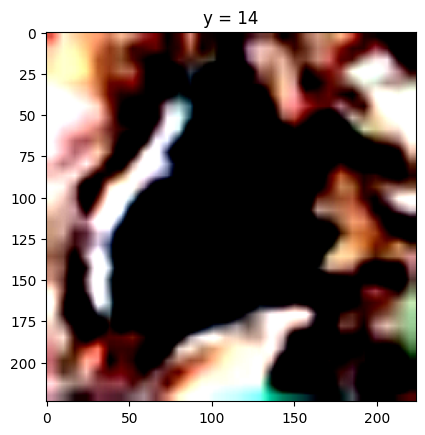

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9131652..2.1484594].


True label:  butterfly
Predicted label:  crab

---------------------------------------------------------------------

Invalid shape (3, 224, 224) for image data
torch.Size([3, 224, 224]) torch.Size([224, 224, 3])


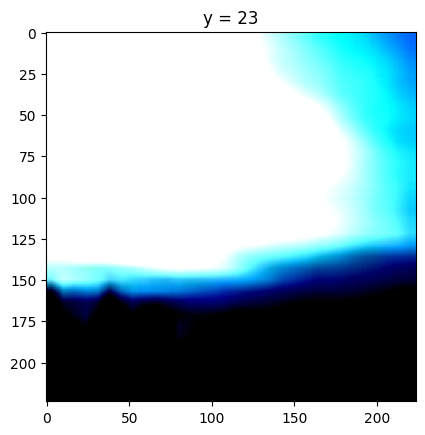

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.6465361].


True label:  cloud
Predicted label:  sea

---------------------------------------------------------------------

Invalid shape (3, 224, 224) for image data
torch.Size([3, 224, 224]) torch.Size([224, 224, 3])


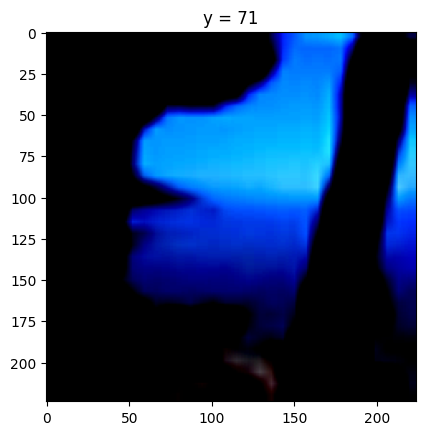

True label:  sea
Predicted label:  pine_tree

---------------------------------------------------------------------



In [24]:
classes_ = val_dataset.classes

# Set the model to evaluation mode
model.eval()

count = 0
i = 0

for x, y in torch.utils.data.DataLoader(dataset=val_dataset, batch_size=1):
    x = x.to(gpu_device)
    y = y.to(gpu_device)
    z = model(x)
    _, yhat = torch.max(z, 1)

    if yhat != y:
        show_data(val_dataset[i])
        print("True label: ", classes_[y.item()])
        print("Predicted label: ", classes_[yhat.item()])
        plt.show()
        count += 1

        print('\n---------------------------------------------------------------------\n')

    if count >= 4:
        break

    i += 1

# Short Report
## Experiment 03

Device used to conduct this experiment:  NVIDIA Tesla P100 16GB

Framework: Pytorch

Augmentation used: Random resized crop, Random horizontal flip, Random rotation, Random affine

Batch size = 32

Optimizer used: Adam (lr:0.0001)

Regularisation techniques used:  Early stopping with patience 10 on training loss, Weight decay

Others: 
- In this study, the ReduceLROnPlateau learning rate scheduler was employed to dynamically adjust the learning rate based on the validation loss with patience 5.
- The Xavier uniform initializer was utilized to initialize the network weights to maintain a good distribution and improve convergence during training.

Key points:
-  This model achieved around 75% accuracy after 50 epochs.  
-  An average Macro and Micro AUC was found to be 0.87.
-  It took around 5 hours and 41 minutes to finish the training.
-  This experiment achieved the highest scores and performance among the four experiments.